# Connecting Mocks and Spectra Examples

The purpose of this notebook is to demonstrate how to generate spectra and apply target selection cuts for various mock catalogs and target types.  Here we generate spectra for targets in a single healpixel with no constraints on the target density (relative to the expected target density) or contaminants.

For code to generate large numbers of spectra over significant patches of sky and to create a representative DESI dataset (with parallelism), see `desitarget/bin/select_mock_targets` and `desitarget.mock.build.targets_truth`.

Finally, note that the various python Classes instantiated here (documented in `desitarget.mock.mockmaker`) are easily extensible to other mock catalogs and galaxy/QSO/stellar physics.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from desiutil.log import get_logger, DEBUG
log = get_logger()

In [3]:
import seaborn as sns
sns.set(style='white', font_scale=1.1, palette='deep')

In [4]:
%matplotlib inline

#### Specify the (required) path to the dust maps and the desired healpixel.

In [5]:
dust_dir = '/Users/ioannis/research/data/sfd_dustmaps/maps'

In [6]:
healpixel = 26030
nside = 64

In [7]:
seed = 555
rand = np.random.RandomState(seed)

#### Define a couple wrapper routines we will use below several times.

In [8]:
def plot_subset(wave, flux, truth, nplot=16, ncol=4, these=None, 
                xlim=None, loc='right', targname='', objtype=''):
    """Plot a random sampling of spectra."""
    
    nspec, npix = flux.shape
    if nspec < nplot:
        nplot = nspec
    
    nrow = np.ceil(nplot / ncol).astype('int')

    if loc == 'left':
        xtxt, ytxt, ha = 0.05, 0.93, 'left'
    else:
        xtxt, ytxt, ha = 0.93, 0.93, 'right'
    
    if these is None:
        these = rand.choice(nspec, nplot, replace=False)
        these = np.sort(these)
        
    ww = (wave > 5500) * (wave < 5550)

    fig, ax = plt.subplots(nrow, ncol, figsize=(2.5*ncol, 2*nrow), sharey=False, sharex=True)
    for thisax, indx in zip(ax.flat, these):
        thisax.plot(wave, flux[indx, :] / np.median(flux[indx, ww]))
        if objtype == 'STAR' or objtype == 'WD':
            thisax.text(xtxt, ytxt, r'$T_{{eff}}$={:.0f} K'.format(truth['TEFF'][indx]), ha=ha,
                 va='top', transform=thisax.transAxes, fontsize=13)
        else:
            thisax.text(xtxt, ytxt, 'z={:.3f}'.format(truth['TRUEZ'][indx]), ha=ha, 
                 va='top', transform=thisax.transAxes, fontsize=13)
            
        thisax.xaxis.set_major_locator(plt.MaxNLocator(3))
        if xlim:
            thisax.set_xlim(xlim)
    for thisax in ax.flat:
        thisax.yaxis.set_ticks([])
        thisax.margins(0.2)
        
    fig.suptitle(targname)
    fig.subplots_adjust(wspace=0.05, hspace=0.05, top=0.93)

In [9]:
def demo_mockmaker(Maker, seed=None, nrand=16, loc='right'):

    TARGET = Maker(seed=seed)
    
    log.info('Reading the mock catalog for {}s'.format(TARGET.objtype))
    tdata = TARGET.read(healpixels=healpixel, nside=nside, dust_dir=dust_dir)
    
    log.info('Generating {} random spectra.'.format(nrand))
    indx = rand.choice(len(tdata['RA']), np.min( (nrand, len(tdata['RA'])) ) )
    tflux, twave, tmeta, ttargets, ttruth = TARGET.make_spectra(tdata, indx=indx)
    
    log.info('Selecting targets')
    TARGET.select_targets(ttargets, ttruth)
    
    plot_subset(twave, tflux, ttruth, loc=loc, targname=tdata['TARGET_NAME'], 
                objtype=TARGET.objtype)

### Tracer QSOs

Both tracer and Lya QSOs contain an underlying QSO spectrum but the Lya QSOs (which we demonstrate below) also include the Lya forest from the latest CoLoRe skewer mocks.

In [10]:
from desitarget.mock.mockmaker import QSOMaker

In [11]:
QSO = QSOMaker(seed=seed)

#### The various `read` methods return a dictionary with target-specific quantities.

In [12]:
data = QSO.read(healpixels=healpixel, nside=nside, dust_dir=dust_dir)

INFO:mockmaker.py:583:readmock: Reading /Users/ioannis/work/desi/mocks/GaussianRandomField/v0.0.5/QSO.fits
INFO:mockmaker.py:595:readmock: Assigning healpix pixels with nside = 64
INFO:mockmaker.py:604:readmock: Trimmed to 114 QSOs in healpixel(s) 26030


In [13]:
for key in sorted(list(data.keys())):
    print('{:>20}, {:3d}, {}'.format(key, len(data[key]), type(data[key])))

           BRICKNAME, 114, <class 'numpy.ndarray'>
                 DEC, 114, <class 'numpy.ndarray'>
                 EBV, 114, <class 'numpy.ndarray'>
               FILES,   1, <class 'list'>
          GALDEPTH_G, 114, <class 'numpy.ndarray'>
          GALDEPTH_R, 114, <class 'numpy.ndarray'>
          GALDEPTH_Z, 114, <class 'numpy.ndarray'>
          MOCKFORMAT,  13, <class 'str'>
              MOCKID, 114, <class 'numpy.ndarray'>
   MW_TRANSMISSION_G, 114, <class 'numpy.ndarray'>
   MW_TRANSMISSION_R, 114, <class 'numpy.ndarray'>
  MW_TRANSMISSION_W1, 114, <class 'numpy.ndarray'>
  MW_TRANSMISSION_W2, 114, <class 'numpy.ndarray'>
   MW_TRANSMISSION_Z, 114, <class 'numpy.ndarray'>
          N_PER_FILE,   1, <class 'list'>
               OBJID, 114, <class 'numpy.ndarray'>
          PSFDEPTH_G, 114, <class 'numpy.ndarray'>
          PSFDEPTH_R, 114, <class 'numpy.ndarray'>
         PSFDEPTH_W1, 114, <class 'numpy.ndarray'>
         PSFDEPTH_W2, 114, <class 'numpy.ndarray'>
        

#### Now we can generate the spectra as well as the targeting catalogs (`targets`) and corresponding truth table.

In [14]:
%time flux, wave, meta, targets, truth = QSO.make_spectra(data)

CPU times: user 4.08 s, sys: 204 ms, total: 4.29 s
Wall time: 4.35 s


In [15]:
print(flux.shape, wave.shape)

(114, 32001) (32001,)


#### The truth (and meta) catalog contains all the input, known target properties.

In [16]:
truth[:2]

TARGETID,MOCKID,CONTAM_TARGET,TRUEZ,TRUESPECTYPE,TEMPLATETYPE,TEMPLATESUBTYPE,TEMPLATEID,SEED,MAG,VDISP,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,OIIFLUX,HBETAFLUX,TEFF,LOGG,FEH
,,,,,,,,,mag,km / s,nanomaggies,nanomaggies,nanomaggies,nanomaggies,nanomaggies,erg / (cm2 s),erg / (cm2 s),K,m / s2,
int64,int64,int64,float32,str10,str10,str10,int32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
0,495878,0,0.139552,QSO,QSO,,0,3083073946,21.3426,-1.0,2.90382,2.99851,3.13995,19.3509,26.174,-1.0,-1.0,-1.0,-1.0,-1.0
0,502558,0,0.43569,QSO,QSO,,1,3083073946,19.682,-1.0,13.4024,13.8509,19.9141,92.6185,139.872,-1.0,-1.0,-1.0,-1.0,-1.0


In [17]:
meta[:2]

OBJTYPE,SUBTYPE,TEMPLATEID,SEED,REDSHIFT,MAG,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,OIIFLUX,HBETAFLUX,EWOII,EWHBETA,D4000,VDISP,OIIDOUBLET,OIIIHBETA,OIIHBETA,NIIHBETA,SIIHBETA,ZMETAL,AGE,TEFF,LOGG,FEH
,,,,,mag,nanomaggies,nanomaggies,nanomaggies,nanomaggies,nanomaggies,erg / (cm2 s),erg / (cm2 s),Angstrom,Angstrom,,km / s,,dex,dex,dex,dex,,Gyr,K,m / s2,
str10,str10,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
QSO,,0,3083073946,0.139552,21.3426,2.90382,2.99851,3.13995,19.3509,26.174,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
QSO,,1,3083073946,0.43569,19.682,13.4024,13.8509,19.9141,92.6185,139.872,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


#### Let's plot some example spectra.

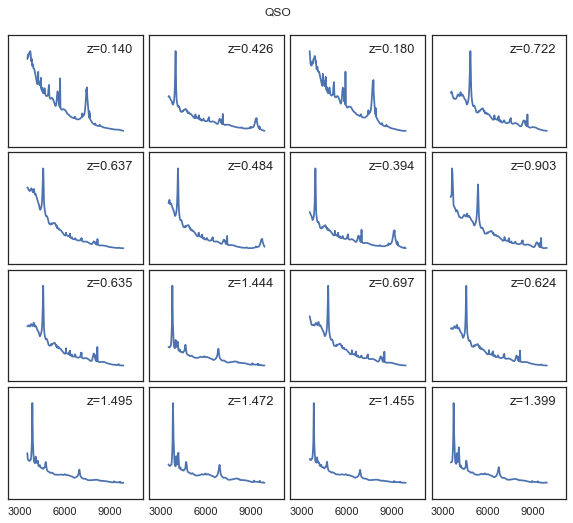

In [18]:
plot_subset(wave, flux, truth, targname='QSO')

#### Select DESI targets, after which point the targets catalog should look just like an imaging targeting catalog.

In other words, `targets` includes noisy photometry as well as targeting information.

In [19]:
QSO.select_targets(targets, truth)

In [20]:
targets[:2]

BRICKID,BRICKNAME,BRICK_OBJID,RA,DEC,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,PSFDEPTH_W1,PSFDEPTH_W2,SHAPEDEV_R,SHAPEDEV_E1,SHAPEDEV_E2,SHAPEEXP_R,SHAPEEXP_E1,SHAPEEXP_E2,SUBPRIORITY,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,HPXPIXEL,OBSCONDITIONS
,,,deg,deg,nanomaggies,nanomaggies,nanomaggies,nanomaggies,nanomaggies,,,,,,1/nanomaggies**2,1/nanomaggies**2,1/nanomaggies**2,1/nanomaggies**2,1/nanomaggies**2,1/nanomaggies**2,1/nanomaggies**2,1/nanomaggies**2,arcsec,,,arcsec,,,,,,,,,
int32,str8,int32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,int64,int64,int64,int64,int64,int64
0,2043p012,0,204.350891113,1.33589243889,2.90792,3.07249,3.37186,18.8122,26.2715,0.939729,0.95899,0.976661,0.996448,0.997817,52.4807,7.72681,1.87068,57.544,13.1826,2.51189,0.0276732,0.438591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,262148,0,0,0,1
0,2046p007,0,204.55027771,0.717863500118,13.4122,13.756,19.8207,89.4035,139.577,0.931901,0.953602,0.973562,0.99597,0.997523,52.4807,7.72681,1.87068,57.544,13.1826,2.51189,0.0276732,0.438591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,262148,0,0,0,1


In [21]:
keep = targets['DESI_TARGET'] != 0
log.info('Identified {} / {} DESI QSO targets.'.format(np.sum(keep), len(targets)))

INFO:<ipython-input-21-39a41d547a3f>:2:<module>: Identified 101 / 114 DESI QSO targets.


### Generating QSO spectra with cosmological Lya skewers proceeds along similar lines.

Note that the current set of Lya mocks (based on CoLoRe) have only 5 A wavelength resolution, so the Lya forest is not very obvious in the spectra below.

In [22]:
from desitarget.mock.mockmaker import LYAMaker

In [23]:
LYA = LYAMaker(seed=seed)

In [24]:
lyadata = LYA.read(healpixels=healpixel, nside=nside, dust_dir=dust_dir)

INFO:mockmaker.py:903:readmock: Reading /Users/ioannis/work/desi/mocks/lya_forest/v2.0.2/master.fits
INFO:mockmaker.py:915:readmock: Assigning healpix pixels with nside = 64
INFO:mockmaker.py:924:readmock: Trimmed to 119 LYAs in healpixel(s) 26030


In [25]:
%time lyaflux, lyawave, lyameta, lyatargets, lyatruth = LYA.make_spectra(lyadata)

CPU times: user 3.69 s, sys: 182 ms, total: 3.88 s
Wall time: 3.93 s


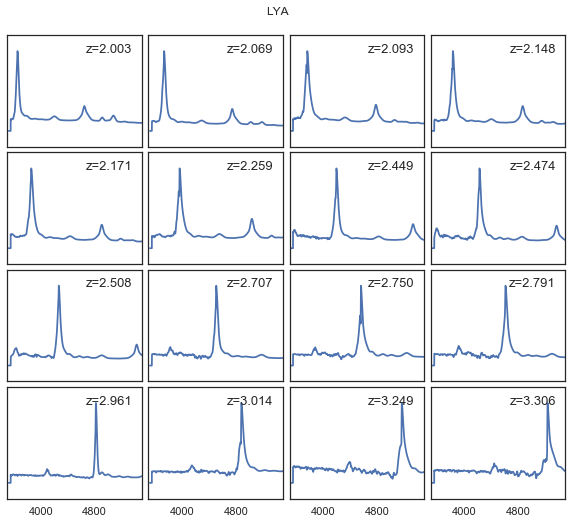

In [26]:
plot_subset(lyawave, lyaflux, lyatruth, xlim=(3500, 5500), targname='LYA')

### Demonstrate the other extragalactic target classes: LRG, ELG, and BGS.

#### LRGs

In [27]:
from desitarget.mock.mockmaker import LRGMaker

INFO:io.py:962:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.4/lrg_templates_v2.0.fits metadata.
INFO:<ipython-input-9-288e41354821>:5:demo_mockmaker: Reading the mock catalog for LRGs
INFO:mockmaker.py:583:readmock: Reading /Users/ioannis/work/desi/mocks/GaussianRandomField/v0.0.5/LRG.fits
INFO:mockmaker.py:595:readmock: Assigning healpix pixels with nside = 64
INFO:mockmaker.py:604:readmock: Trimmed to 678 LRGs in healpixel(s) 26030
INFO:io.py:974:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.4/lrg_templates_v2.0.fits
INFO:<ipython-input-9-288e41354821>:8:demo_mockmaker: Generating 16 random spectra.
INFO:<ipython-input-9-288e41354821>:12:demo_mockmaker: Selecting targets
CPU times: user 5.72 s, sys: 915 ms, total: 6.63 s
Wall time: 6.14 s


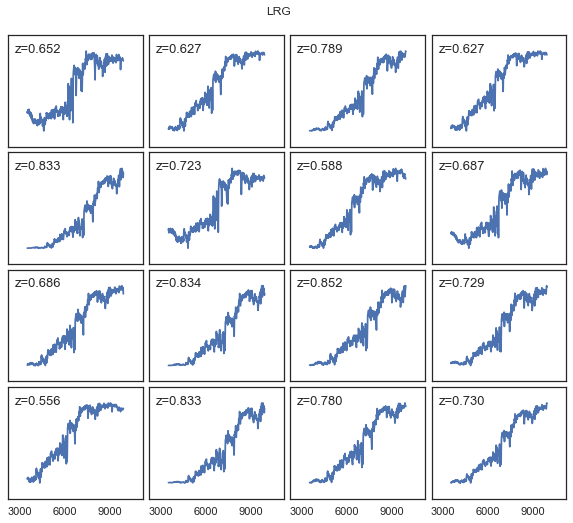

In [28]:
%time demo_mockmaker(LRGMaker, seed=seed, loc='left')

#### ELGs

In [29]:
from desitarget.mock.mockmaker import ELGMaker

INFO:io.py:962:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.4/elg_templates_v2.0.fits metadata.
INFO:<ipython-input-9-288e41354821>:5:demo_mockmaker: Reading the mock catalog for ELGs
INFO:mockmaker.py:583:readmock: Reading /Users/ioannis/work/desi/mocks/GaussianRandomField/v0.0.5/ELG.fits
INFO:mockmaker.py:595:readmock: Assigning healpix pixels with nside = 64
INFO:mockmaker.py:604:readmock: Trimmed to 3921 ELGs in healpixel(s) 26030
INFO:io.py:974:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.4/elg_templates_v2.0.fits
INFO:<ipython-input-9-288e41354821>:8:demo_mockmaker: Generating 16 random spectra.
INFO:<ipython-input-9-288e41354821>:12:demo_mockmaker: Selecting targets
CPU times: user 17.4 s, sys: 3.72 s, total: 21.1 s
Wall time: 20.4 s


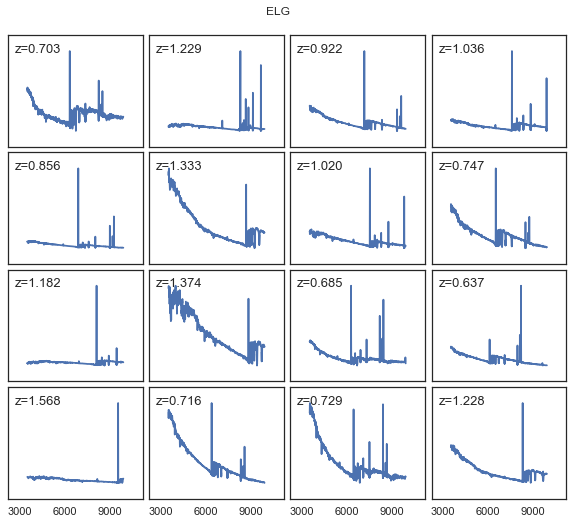

In [30]:
%time demo_mockmaker(ELGMaker, seed=seed, loc='left')

#### BGS

In [31]:
from desitarget.mock.mockmaker import BGSMaker

INFO:io.py:962:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.4/bgs_templates_v2.1.fits metadata.
INFO:<ipython-input-9-288e41354821>:5:demo_mockmaker: Reading the mock catalog for BGSs
INFO:mockmaker.py:1030:readmock: Assigning healpix pixels with nside = 64
INFO:mockmaker.py:1040:readmock: Trimmed to 2338 BGSs in healpixels 26030
INFO:io.py:974:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.4/bgs_templates_v2.1.fits
INFO:<ipython-input-9-288e41354821>:8:demo_mockmaker: Generating 16 random spectra.
INFO:<ipython-input-9-288e41354821>:12:demo_mockmaker: Selecting targets
CPU times: user 14.7 s, sys: 2.63 s, total: 17.3 s
Wall time: 16.9 s


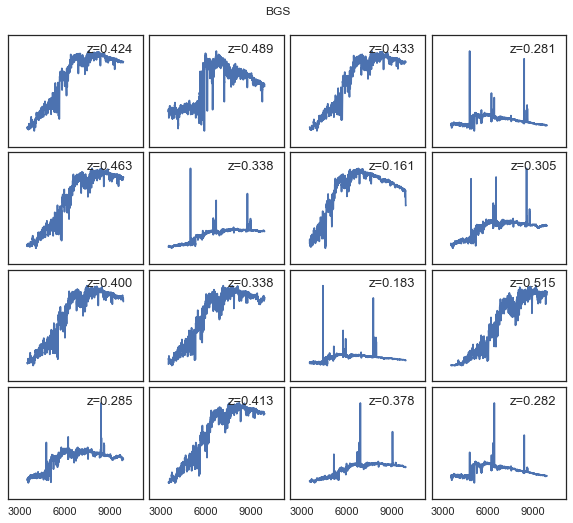

In [32]:
%time demo_mockmaker(BGSMaker, seed=seed)

### Next, demonstrate how to generate spectra of stars...

#### MWS_MAIN

In [33]:
from desitarget.mock.mockmaker import MWS_MAINMaker

INFO:io.py:974:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.4/star_templates_v2.1.fits
INFO:<ipython-input-9-288e41354821>:5:demo_mockmaker: Reading the mock catalog for STARs
INFO:mockmaker.py:725:readmock: Reading /Users/ioannis/work/desi/mocks/mws/galaxia/alpha/v0.0.5/healpix/8/4/406/mock_allsky_galaxia_desi-8-406.fits
INFO:io.py:974:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.4/star_templates_v2.1.fits
INFO:<ipython-input-9-288e41354821>:8:demo_mockmaker: Generating 16 random spectra.
INFO:<ipython-input-9-288e41354821>:12:demo_mockmaker: Selecting targets
CPU times: user 2.77 s, sys: 1.21 s, total: 3.98 s
Wall time: 5.33 s


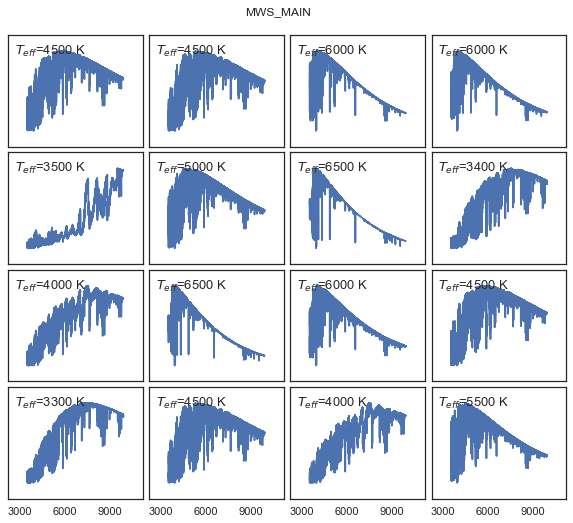

In [34]:
%time demo_mockmaker(MWS_MAINMaker, seed=seed, loc='left')

#### MWS_NEARBY

In [35]:
from desitarget.mock.mockmaker import MWS_NEARBYMaker

INFO:io.py:974:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.4/star_templates_v2.1.fits
INFO:<ipython-input-9-288e41354821>:5:demo_mockmaker: Reading the mock catalog for STARs
INFO:mockmaker.py:1253:readmock: Reading /Users/ioannis/work/desi/mocks/mws/100pc/v0.0.3/mock_100pc.fits
INFO:mockmaker.py:1265:readmock: Assigning healpix pixels with nside = 64
INFO:mockmaker.py:1274:readmock: Trimmed to 7 MWS_NEARBYs in healpixels 26030
INFO:io.py:974:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.4/star_templates_v2.1.fits
INFO:<ipython-input-9-288e41354821>:8:demo_mockmaker: Generating 16 random spectra.
INFO:<ipython-input-9-288e41354821>:12:demo_mockmaker: Selecting targets
CPU times: user 2.49 s, sys: 1.02 s, total: 3.51 s
Wall time: 3.57 s


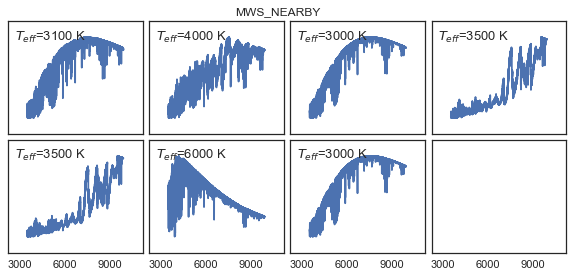

In [36]:
%time demo_mockmaker(MWS_NEARBYMaker, seed=seed, loc='left')

#### White dwarfs (WDs)

In [37]:
from desitarget.mock.mockmaker import WDMaker

INFO:io.py:962:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.4/wd_templates_v2.1.fits metadata.
INFO:io.py:962:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.4/wd_templates_v2.1.fits metadata.
INFO:<ipython-input-9-288e41354821>:5:demo_mockmaker: Reading the mock catalog for WDs
INFO:mockmaker.py:1143:readmock: Reading /Users/ioannis/work/desi/mocks/mws/wd/v0.0.2/mock_wd.fits
INFO:mockmaker.py:1155:readmock: Assigning healpix pixels with nside = 64
INFO:mockmaker.py:1164:readmock: Trimmed to 12 WDs in healpixels 26030
INFO:io.py:974:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.4/wd_templates_v2.1.fits
INFO:io.py:974:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.4/wd_templates_v2.1.fits
INFO:<ipython-input-9-288e41354821>:8:demo_mockmaker: Generating 16 random spectra.
INFO:<ipython-input-9-288e41354821>:1

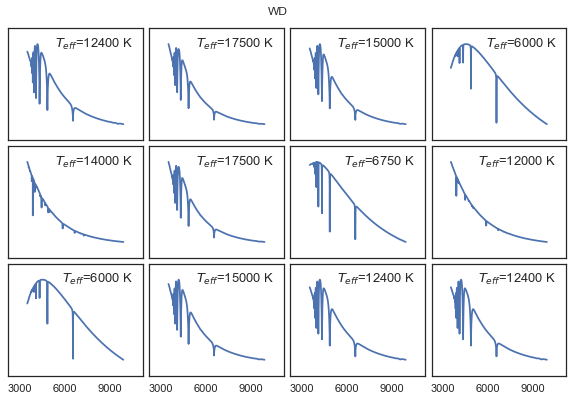

In [38]:
%time demo_mockmaker(WDMaker, seed=seed, loc='right')

### Finally demonstrate how to generate (empyt) SKY spectra.

In [39]:
from desitarget.mock.mockmaker import SKYMaker

In [40]:
SKY = SKYMaker(seed=seed)

In [41]:
skydata = SKY.read(healpixels=healpixel, nside=nside, dust_dir=dust_dir)

INFO:mockmaker.py:583:readmock: Reading /Users/ioannis/work/desi/mocks/GaussianRandomField/v0.0.1/2048/random.fits
INFO:mockmaker.py:595:readmock: Assigning healpix pixels with nside = 64
INFO:mockmaker.py:604:readmock: Trimmed to 1659 SKYs in healpixel(s) 26030


In [42]:
skyflux, skywave, skymeta, skytargets, skytruth = SKY.make_spectra(skydata)

In [43]:
SKY.select_targets(skytargets, skytruth)